# Introdução

O presente relatório, através da análise de Big Data, visa identificar as vias da cidade com buracos, estimar os custos de reparo/manutenção e identificar os segmentos que provocam maior impacto negativo no bem-estar dos cidadãos.

# Parametrização das Variáveis

## Definindo os Parâmetros

In [1]:
%env PROJ_LIB=/home/master/anaconda3/envs/ox_gpd/share/proj

env: PROJ_LIB=/home/master/anaconda3/envs/ox_gpd/share/proj


In [2]:
from datetime import datetime as dt
from datetime import timedelta as td

cost_per_meter = 23.4
lane_size = 2.8

# city = 'Miraflores'
# table = 'pe_lima_waze_alerts'
# start_date = dt(2019,6,15)
# end_date = dt(2019,6,30)

# osm_place = "Distrito de Miraflores"

city = 'São Paulo'
table = 'br_saopaulo_waze_alerts'
start_date = dt(2019,8,1)
end_date = dt(2019,8,31)
osm_place = {'city' : 'São Paulo',
             'state' : 'São Paulo',
             'country' : 'Brasil'}
which_result=1

## Imports and Configuration

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import logging
import warnings
import datetime
import pytz
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx 
import osmnx as ox
import matplotlib.pyplot as plt

from math import ceil
from matplotlib import colors, cm
from pathlib import Path 
from shapely.geometry import Point
from IPython.display import display, Markdown
from scipy.stats import pareto
from scipy.spatial import cKDTree
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.set_option('display.max_columns', None)

current_path = Path().resolve()
abs_path = str(current_path.parent)
sys.path.append(abs_path)

RAW_PATH = current_path.parent / 'data' / 'raw' / city
OUTPUT_PATH = current_path.parent / 'data' / 'output' / city

warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('boto3').setLevel(logging.CRITICAL)
logging.getLogger('botocore').setLevel(logging.CRITICAL)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)


In [4]:
import scripts.pot_holes_cost as phc
from scripts.mod_simplify import simplify_graph

In [5]:
from h3 import h3
import folium
import json
from geojson.feature import *

import branca.colormap as bcm
from branca.colormap import linear

from IPython.display import display, HTML, Image
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster

from pandas.io.json import json_normalize

In [6]:
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon

In [7]:
# print(plt.rcParams['figure.autolayout'])
# print(plt.rcParams['figure.figsize'])
# print(plt.rcParams['axes.labelsize'])
# print(plt.rcParams['axes.titlesize'])
# print(plt.rcParams['font.size'] )
# print(plt.rcParams['lines.linewidth'] )
# print(plt.rcParams['lines.markersize'])
# print(plt.rcParams['legend.fontsize'] )

# print(plt.rcParams['text.usetex'] )
# print(plt.rcParams['font.family'] )
# print(plt.rcParams['font.serif'] )

In [8]:
plt.rcParams['figure.autolayout'] = False
# plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14
# plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = "DejaVu Sans"
# plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [9]:
date_string_parser='%d/%m/%y'
print(f"""Os parâmetros definidos para elaboração deste relatório são os seguintes:

Vias:

Custo médio por metro quadro de reparo das vias: {cost_per_meter:.2f}U$/m^2
Largura média das vias: {lane_size:.2f}m

Período:
Data de ínicio dos alertas: {start_date.strftime(date_string_parser)}
Data final dos alertas: {end_date.strftime(date_string_parser)}""")

Os parâmetros definidos para elaboração deste relatório são os seguintes:

Vias:

Custo médio por metro quadro de reparo das vias: 23.40U$/m^2
Largura média das vias: 2.80m

Período:
Data de ínicio dos alertas: 01/08/19
Data final dos alertas: 31/08/19


# Obtendo os Dados

## Buracos

Os dados relativo aos buracos foram extraídos de nosso servidor de Big Data que armazena as informações do Waze. Os alertas de buracos são criados pelos próprios usuários do aplicativo para alertar as demais pessoas sobre as condições da via.

In [10]:
pot_holes = phc.download_potholes_data(template_fp='../templates/pot_holes.sql', city=city, table=table, 
                                       start_date=start_date, end_date=end_date, workgroup='Test')

In [11]:
display(Markdown(
    f"A tabela abaixo mostra os cinco buracos com a maior quantidade de reclamações da cidade no período entre {start_date.strftime('%d/%m/%y')} - {end_date.strftime('%d/%m/%y')}"))

A tabela abaixo mostra os cinco buracos com a maior quantidade de reclamações da cidade no período entre 01/08/19 - 31/08/19

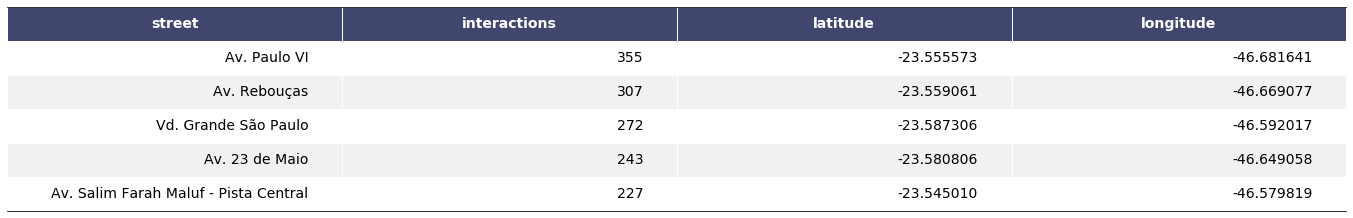

In [102]:
top5 = pot_holes[['street', 'interactions', 'latitude', 'longitude', ]].sort_values('interactions', ascending=False).head()
top5['latitude'] = top5['latitude'].apply(lambda x: f"{x:,.6f}")
top5['longitude'] = top5['longitude'].apply(lambda x: f"{x:,.6f}")
fig, ax, table = phc.render_mpl_table(top5, 'potholes_top5.png', city, col_width=6)
# ax.set_xlabel(f"Tabela 1: Informações sobre os cinco alertas com maior número de interações");

In [13]:
display(Markdown(f"""Total de alertas: {pot_holes.shape[0]}

Total de interações: {pot_holes.interactions.sum()}"""))

Total de alertas: 31280

Total de interações: 355471

## Open Street Maps (OSM)

Para complementar nosso estudo, baixamos as informações das vias da cidade disponibilizadas no Open Street Maps, um projeto de mapeamento colaborativo para criar um mapa livre e editável do mundo. Com uma rede de mais de 2 milhões de colaboradores ao redor do mundo, o OSM oferece mapas detalhados de diversas localidades, sendo uma excelente fonte de informação sobre a estrutura viária dos municípios.

In [14]:
if osm_place:
    G = phc.download_osm_graph(city, osm_place, simplify=False, which_result=which_result)
else:
    lats = pot_holes['latitude'].values
    longs = pot_holes['longitude'].values
    north, south, east, west = max(lats), min(lats), max(longs), min(longs)
    G = phc.download_osm_graph(city, north=north, south=south, east=east, west=west, simplify=False, cached=False, cache_result=False)

In [15]:
G_proj = ox.project_graph(G) 

In [16]:
layers = gpd.read_file(str(RAW_PATH/'DEINFO_REGIAO8.shp'))

In [17]:
layers.crs = '+proj=utm +zone=23 +south +ellps=aust_SA +towgs84=-67.35,3.88,-38.22,0,0,0,0 +units=m +no_defs'

In [18]:
layers = layers.to_crs(G_proj.graph['crs'])

A imagem abaixo mostra todas as vias públicas da cidade registradas no OSM. Destacam-se também as divisões das oito regiões administrativas do muncípio.

In [19]:
fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=10, show=False, axis_off=False, edge_linewidth=0.2)
ax.margins(0)
ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.set_xlabel(f"Figura 1: Vias públicas da cidade de {city} obtidas através do Open Street Maps");

In [20]:
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in layers['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='w', ec='r', linewidth=2, alpha=0.3, zorder=-1)
            ax.add_patch(patch)

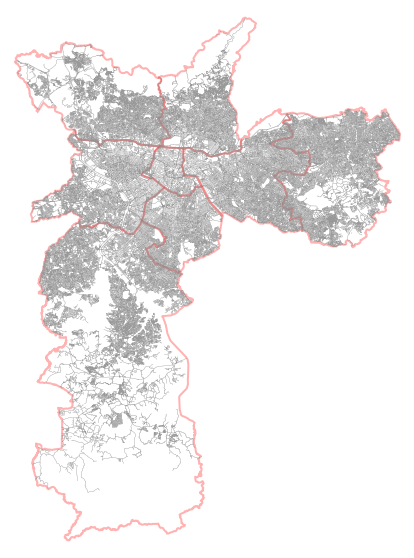

In [21]:
# optionally set up the axes extents all nicely
margin = 0.02
west, south, east, north = layers.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
fig

# Treat Data <a class='tocSkip'>

## Potholes to shapely <a class='tocSkip'>

In [22]:
pot_holes = phc.treat_potholes_points(pot_holes)

# Conectando os Alertas as Ruas

In [23]:
# We use projected graph for better accuracy in KDTree method
edges_with_potholes = phc.match_roads_to_points(city, pot_holes, G_proj, by='hex')

In [24]:
nx.set_edge_attributes(G_proj, 0, 'alerts_count')
nx.set_edge_attributes(G_proj, 0, 'interactions')
nx.set_edge_attributes(G_proj, edges_with_potholes)

In [25]:
nx.set_edge_attributes(G, 0, 'alerts_count')
nx.set_edge_attributes(G, 0, 'interactions')
nx.set_edge_attributes(G, edges_with_potholes)

In [26]:
### Feito o match, iremos analisar os segmentos com os buracos
nodes, edges = ox.graph_to_gdfs(G) 

A imagem abaixo mostra todos os trechos de rua onde foi reportado alertas de buracos, na qual a intensidade das cores indica a quantidade de interações dos usuários do aplicativo com os tais alertas.

In [27]:
max_interaction = edges.interactions.max()

In [28]:
def plot_city_potholes(G_proj, layers, max_interaction):
    
    interactions = []
    edges_color = []
    edges_width = []
    
    norm = colors.Normalize(vmin=0, vmax=max_interaction)
    scalarMap  = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('autumn_r'))
    
    for _,_,d in G_proj.edges(data=True):
        interactions.append(d.get('interactions', 0))
        if d.get('interactions', 0) > 0:
            edges_color.append(scalarMap.to_rgba(d['interactions']))
        else:
            edges_color.append('#bfbfbf')
        if d.get('alerts_count', 0) > 0:
            edges_width.append(1)
        else: 
            edges_width.append(0.2) 
    
    edges_color = list(map(colors.to_rgba, edges_color))
    
    
    fig, ax = ox.plot_graph(G_proj, node_size=0, fig_height=11, edge_color=edges_color,edge_linewidth=edges_width,
                           show=False, axis_off=False)
    
    ax.set_facecolor('k')
    ax.margins(0)
    ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False);

    for geometry in layers.loc[:, 'geometry'].values:
        if isinstance(geometry, (Polygon, MultiPolygon)):
            if isinstance(geometry, Polygon):
                geometry = MultiPolygon([geometry])
            for polygon in geometry:
                patch = PolygonPatch(polygon, fc='k', ec='#000080', linewidth=1.5, alpha=0.4, zorder=-1)
                ax.add_patch(patch)

    margin = 0.1
    west, south, east, north = layers.unary_union.bounds
    margin_ns = (north - south) * margin
    margin_ew = (east - west) * margin
    ax.set_ylim((south - margin_ns, north + margin_ns))
    ax.set_xlim((west - margin_ew, east + margin_ew))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cb = fig.colorbar(scalarMap, cax=cax)
    cb.set_label('Quantidade Total de Interações')
    return fig

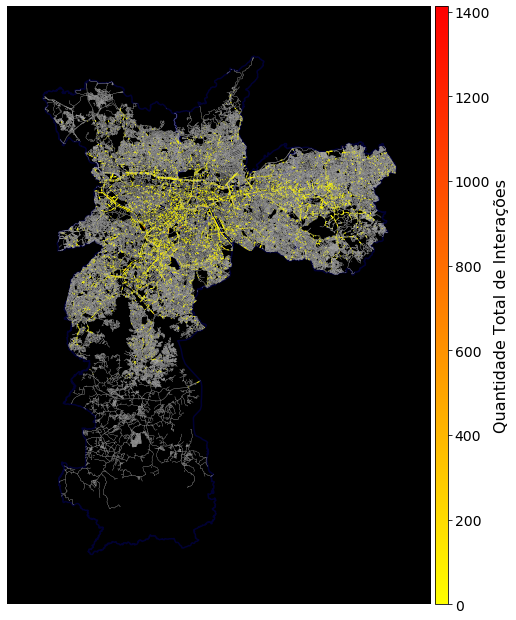

In [29]:
plot_city_potholes(G_proj, layers, max_interaction)

Para melhor visualizar a localização dos alertas de buracos nas vias, iremos observar separadamaente cada uma das oito regiões. Note que a escala de cores continua sendo a mesma para todas as regiões.

In [30]:
h3_hex = phc.get_hex_KDTrees(city)

In [31]:
h3_hex['geometry'] = h3_hex.hex_id.apply(lambda hid: Polygon(h3.h3_to_geo_boundary(hid, geo_json=True)))

In [32]:
h3_hex = gpd.GeoDataFrame(h3_hex)

In [33]:
h3_hex.crs = G.graph['crs']

In [34]:
h3_hex = h3_hex.to_crs(layers.crs)

In [35]:
for _, row in layers.iterrows():
    h3_hex[row['NOME']] = h3_hex.geometry.apply(row['geometry'].intersects)

In [36]:
for hix, hex_id in h3_hex.iterrows():
    for region in layers['NOME']:
        edges.loc[hex_id['edges_idx_in_hex'], region+"_cand"] = hex_id[region]

In [37]:
edges['verify'] = edges.iloc[:,-8:].sum(axis=1)

In [38]:
layers_latlon = layers.to_crs(edges.crs)

In [39]:
for _, row in layers_latlon.iterrows():
    region = row['NOME']
    edges.loc[edges['verify'] == 1, region] = edges.loc[edges['verify'] == 1, region+"_cand"]
    edges.loc[edges['verify'] != 1, region] = edges[edges['verify'] != 1].geometry.apply(row['geometry'].intersects)

In [40]:
edges['verify_2'] = edges.iloc[:,-8:].sum(axis=1)

In [41]:
edges = edges[edges.columns.drop(list(edges.filter(like='_cand')))].drop(columns=['verify','verify_2'])

In [42]:
# Operação poderia ser paralelizada, potencial problema com memória.
Graphs_proj = {}
for region in layers.NOME:
    edges_sub = edges.loc[edges[region]].to_crs(layers.crs)
    nodes_sub = nodes.loc[nodes.osmid.isin(set(edges_sub.u.values).union(set(edges_sub.v.values)))].to_crs(layers.crs)
    nodes_sub.gdf_name = region
    Graphs_proj[region] = ox.gdfs_to_graph(gdf_nodes=nodes_sub, gdf_edges=edges_sub)
    del edges_sub, nodes_sub

In [43]:
def plot_region_potholes(Graphs_proj, layers, region, max_interaction):
    
    interactions = []
    edges_color = []
    edges_width = []
    
    norm = colors.Normalize(vmin=0, vmax=max_interaction)
    scalarMap  = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('autumn_r'))
    
    for _,_,d in Graphs_proj[region].edges(data=True):
        interactions.append(d.get('interactions', 0))
        if d.get('interactions', 0) > 0:
            edges_color.append(scalarMap.to_rgba(d['interactions']))
        else:
            edges_color.append('#bfbfbf')
        if d.get('alerts_count', 0) > 0:
            edges_width.append(3)
        else: 
            edges_width.append(0.2) 
    
    edges_color = list(map(colors.to_rgba, edges_color))
    
    
    fig, ax = ox.plot_graph(Graphs_proj[region], node_size=0, fig_height=10, edge_color=edges_color,edge_linewidth=edges_width,
                           show=False, axis_off=False)
    
    ax.margins(0)
    ax.tick_params(which='both', left=False, bottom=False,  labelleft=False, labelbottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False);

    for geometry in layers.loc[layers.NOME == region, 'geometry'].values:
        if isinstance(geometry, (Polygon, MultiPolygon)):
            if isinstance(geometry, Polygon):
                geometry = MultiPolygon([geometry])
            for polygon in geometry:
                patch = PolygonPatch(polygon, fc='w', ec='#000080', linewidth=1.5, alpha=0.4, zorder=-1)
                ax.add_patch(patch)

    margin = 0.1
    west, south, east, north = layers.loc[layers.NOME == region, 'geometry'].values[0].bounds
    margin_ns = (north - south) * margin
    margin_ew = (east - west) * margin
    ax.set_ylim((south - margin_ns, north + margin_ns))
    ax.set_xlim((west - margin_ew, east + margin_ew))
    cb = fig.colorbar(scalarMap)
    return fig

# Estatísticas Descritivas

In [44]:
stats = phc.generate_basic_stats(city, G)#, cost_per_meter, lane_size, avg_lane)

A tabela a seguir resume algumas estatísticas sobre as vias da cidade, indicando quantos segmentos possuem buracos e estimando sua representação no total.

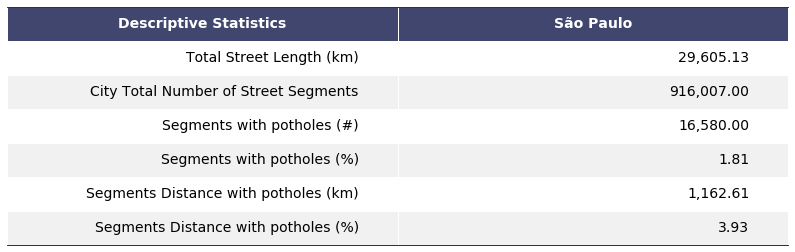

In [45]:
stats_table = stats.copy()
stats_table[city] = stats[city].apply(lambda x: f"{x:,.2f}")
stats_table.index.names = ["Descriptive Statistics"]
fig, ax, table = phc.render_mpl_table(stats_table.reset_index(), 'stats_table.png', city, col_width=7)
#ax.set_xlabel(f"Tabela 2: Estatísticas de buracos nas vias");

# Custo Estimado

A fórmula de cálculo do custo é direta, $Custo = Comprimento * LarguraDaVia * Custo/m^2$, na qual largura da via e comprimento são dados em metros. Aqui, assumimos que os buracos não possuem largura maior que as faixas da via, logo, apenas uma das faixas deveriam ser contabilizadas no custo total estimado de reparo.

A tabela a seguir indica os valores dos parâmetros assumidos nesse relatório e o custo estimado de reparo de todos os segmentos de ruas com buracos reportados no período abordado.

In [46]:
cost_table = phc.generate_cost_estimates(city, G, cost_per_meter, lane_size)
cost_table[city] = cost_table[city].apply(lambda x: f"{x:,.2f}")
cost_table.index.names = ['Estimated Cost Parameters and Value']

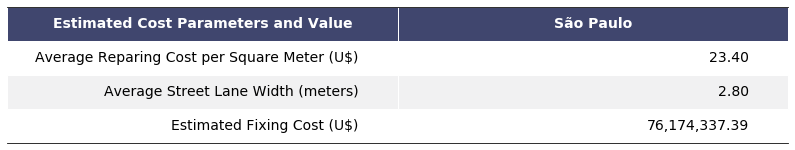

In [47]:
fig, ax, table = phc.render_mpl_table(cost_table.reset_index(), 'cost_table.png', city, col_width=7)
#ax.set_xlabel(f"Tabela 3: Custo Estimado e Parâmetros utilizados");

In [48]:
# ax1 = edges['cost'].hist(figsize=[15,10])
# ax1.grid(axis='x')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.set_ylabel("Número de Segmentos de Rua")
# ax1.set_xlabel("Quantidade de Intereções nos Alertas dos Segmentos")
# ax1.set_title("Distribuição de Segmentos por Quantidade de Interações");

# Interações com Alertas de Buracos

## Segmentos e Interações

O histograma a seguir indica a distribuição dos segmentos de rua de acordo com a quantidade de interações que cada segmento obteve, não contabilizando aqueles com nenhuma interação.

Ou seja, as colunas mais à direita no gráfico a seguir indicam os segmentos de vias com mais reclamações/iterações, representando aqueles que mais afetam os usuário.

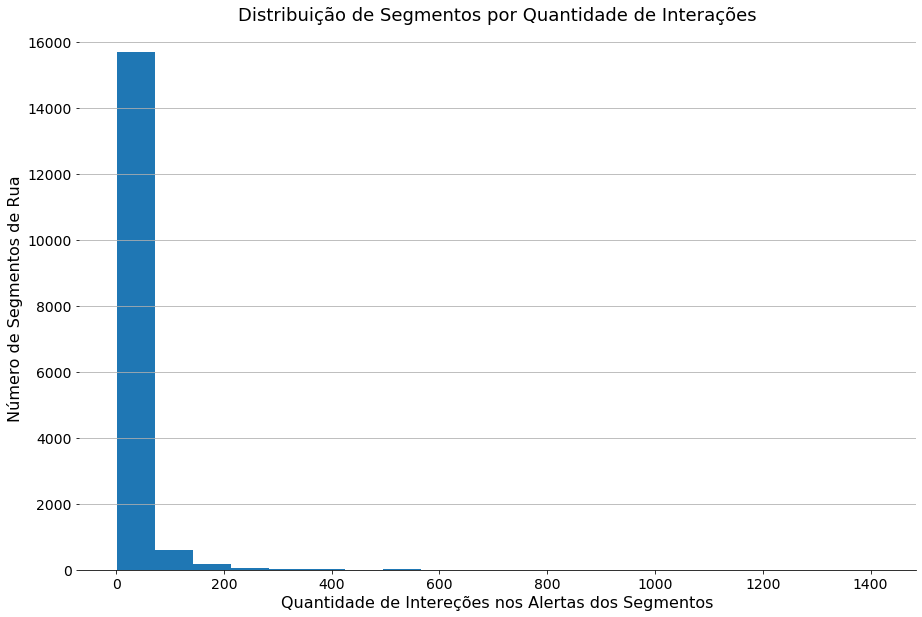

In [49]:
ax1 = edges[edges['interactions']>0]['interactions'].hist(figsize=[15,10], bins=20)
ax1.grid(axis='x')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel("Número de Segmentos de Rua")
ax1.set_xlabel("Quantidade de Intereções nos Alertas dos Segmentos")
ax1.set_title("Distribuição de Segmentos por Quantidade de Interações");

## Princípio de Pareto

In [50]:
edges = phc.estimate_cost(edges, cost_per_meter, lane_size)

In [51]:
edges = phc.calculate_pareto(edges)

In [52]:
for region in layers.NOME:
    edges.loc[edges[region], f"pareto_{region}"] = phc.calculate_pareto(edges.loc[edges[region]], suffix='_'+region)[f"pareto_{region}"]

Da última figura, nota-se que poucos segmentos são responsáveis por muitas interações, enquanto há vários segmentos com poucas interações dos usuários, isto é, há buracos que provocam maior impacto no trânsito e no bem-estar dos cidadãos.

Explorando mais a fundo essa relação de interações por segmento, queremos saber o quão próximo esse padrão está do Princípio de Pareto, ou seja, se 20% dos segmentos são responsáveis por 80% das interações em contraste a uma distribuição uniforme. A imagem abaixo contrasta a distribuição real e a uniforme.

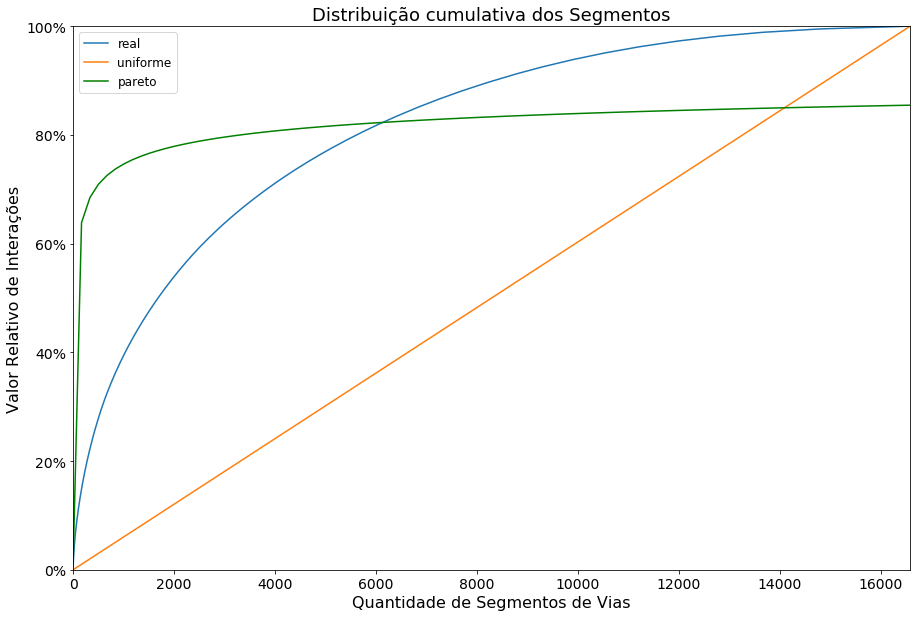

In [53]:
# calculating Pareto parameters
x_max = edges[['pareto']].dropna().shape[0]
b= -(np.log(0.2)/np.log(0.2*edges[['pareto']].dropna().shape[0]))
loc= -1
x = np.linspace(pareto.ppf(0.01, b, loc=loc), x_max, 100)

# plotting graphs
plot = edges[['pareto']].sort_values(by='pareto').rename(columns={"pareto":"real"}).dropna().reset_index().plot(y='real', figsize=(15,10))
fig = plot.get_figure()
plot.plot([0, x_max], [0,100], label='uniforme')
plot.plot(x, pareto.cdf(x, b, loc=loc)*100, 'g-', label='pareto')
plot.legend()
plot.set_ylim(0,100)
plot.set_xlim(0,x_max)
plot.set_yticklabels(['0%', '20%', '40%', '60%', '80%','100%'])
plot.set_title("Distribuição cumulativa dos Segmentos")
plot.set_ylabel("Valor Relativo de Interações")
plot.set_xlabel("Quantidade de Segmentos de Vias")
fig.savefig(OUTPUT_PATH / "cumulative_distribution.png")

In [54]:
pareto_df = phc.summary_pareto(city, edges)

Visando a otimização dos recursos públicos e as restrições orçamentárias, podemos formular uma estratégia de reparo das vias que priorize os buracos que provocam maior transtorno aos motoristas, o qual podemos inferir através dos números de interações com alertas de buracos dos usuários do Waze que transitam pela cidade.

Ordenando os segmentos de vias pelo seu número de interações de modo descendente e calculando seu custo de reparo, podemos identificar qual a porcentagem das reclamações poderiam ser atendidas para diferentes orçamentos. A tabela abaixo expõe essa informação.

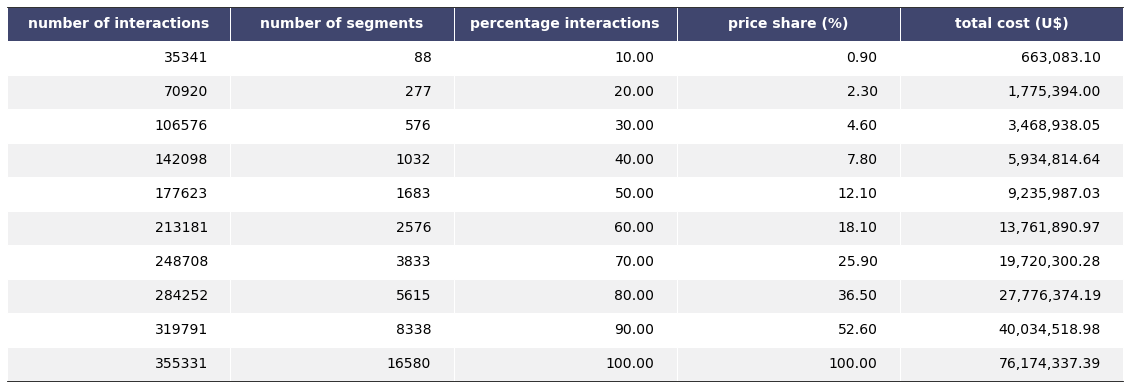

In [55]:
pareto_table = pareto_df.copy()
for col in pareto_df.columns:
    if col not in ['number of segments', 'number of interactions']:
        pareto_table[col] = pareto_df[col].apply(lambda x: f"{x:,.2f}")
fig, ax, table = phc.render_mpl_table(pareto_table[2::2], 'pareto_table.png', city)
#ax.set_xlabel(f"Tabla 4: Princípio de Pareto");

A imagem abaixo mostra a relação entre o percentual do custo total versus o percentual de reclamações. Observa-se que aplicando adequadamente os recursos é possível atender grande volume das reclamações.

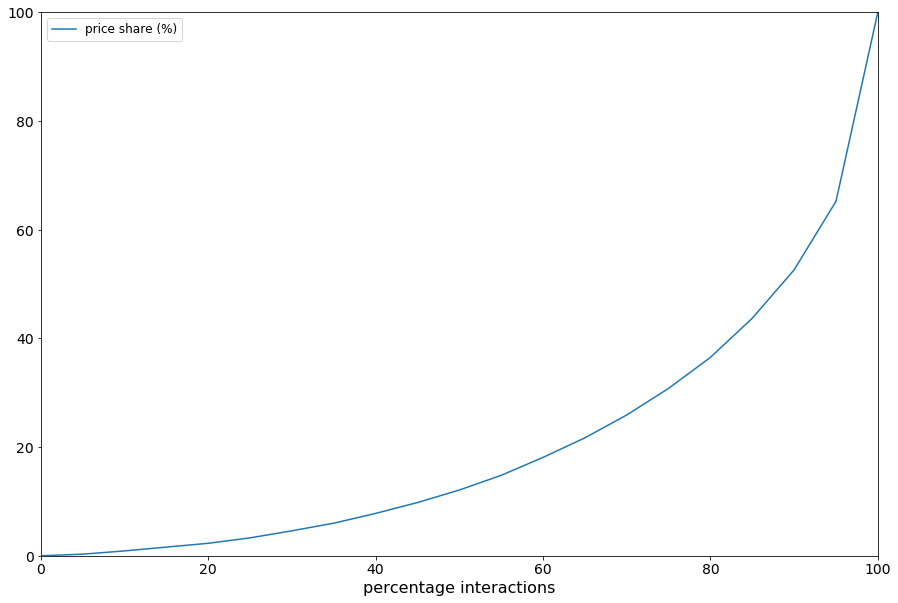

In [56]:
plot = pareto_df.plot(x='percentage interactions', y='price share (%)', figsize=(15,10))
fig = plot.get_figure()
plot.set_ylim(0,100)
plot.set_xlim(0,100)
fig.savefig(OUTPUT_PATH / "priceshare x percentage_interactions.png")

## Mapas das vias com mais reclamações.

As imagens a seguir indicam as posições dos buracos que mais concentram as interações dos usuários. Na primeira seção identificamos os principais alertas de toda a cidade, na segunda parte, destacamos os alertas de cada região. 

In [156]:
Gcopy = G_proj.copy()

In [157]:
nx.set_edge_attributes(Gcopy, 0, 'alerts_count')
nx.set_edge_attributes(Gcopy, 0, 'interactions')

In [158]:
with open(str(RAW_PATH/'edges_final.p'), 'wb') as f:
    pickle.dump(edges, f)

In [159]:
edges_pareto = edges[edges['alerts_count']>0].rename(columns={'key':'k'}).drop(
    columns=['access','bridge','geometry','hex_set','highway','junction','landuse','lanes','length','maxspeed','oneway',
            'osmid','ref','service','tunnel','width'])

### Visão Geral da Cidade

In [160]:
top = 10
display(Markdown(f"""Localização dos Buracos que concentram <b>{top}%</b> das reclamações."""))
print(f"Custo de reparo estimado em U${pareto_df.loc[pareto_df['percentage interactions']==top, 'total cost (U$)'].iloc[0]:,.2f}")

Localização dos Buracos que concentram <b>10%</b> das reclamações.

Custo de reparo estimado em U$663,083.10


In [161]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto['pareto'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Gcopy, edges_with_potholes_pareto)

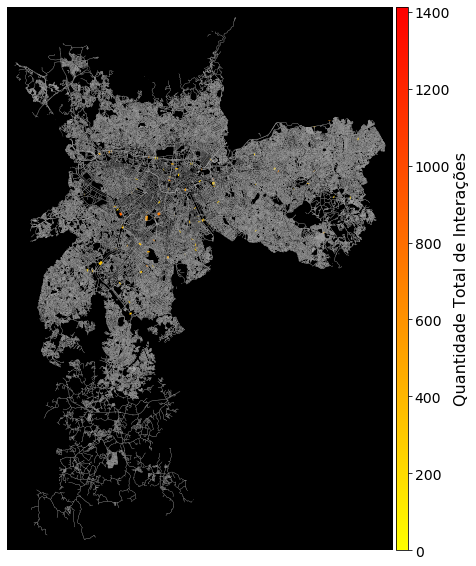

In [162]:
phc.plot_graph_potholes(Gcopy, fig_width=None, fig_height=10)

\newpage

### Visualizando por Região

In [163]:
del Gcopy

In [164]:
Graphs_copy = {region: graph.copy() for region, graph in Graphs_proj.items()}

In [165]:
for graph in Graphs_copy.values():
    nx.set_edge_attributes(graph, 0, 'alerts_count')
    nx.set_edge_attributes(graph, 0, 'interactions')

### Centro <a class='tocSkip'>

In [123]:
region = 'Centro'

In [124]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

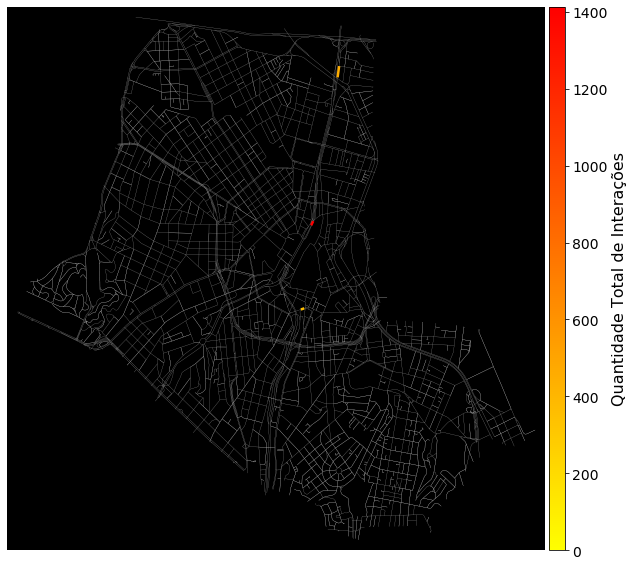

In [125]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

Tabela das Vias que concentram 10% das reclamações na região Centro.

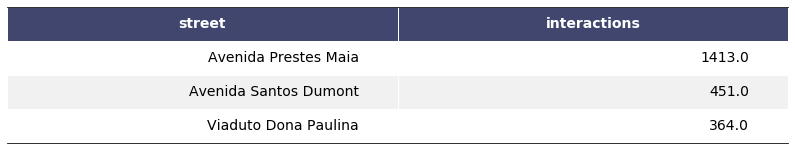

In [126]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=7)

\newpage

### Norte 1 <a class='tocSkip'>

In [127]:
region = 'Norte 1'

In [128]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

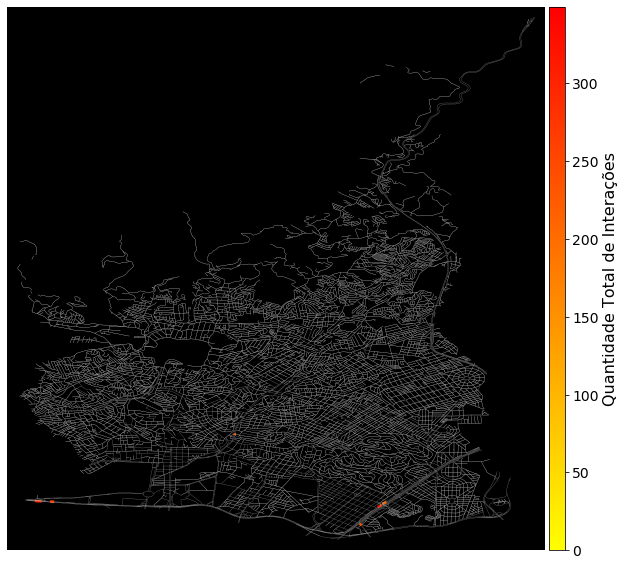

In [129]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

Tabela das Vias que concentram 10% das reclamações na região Norte 1.

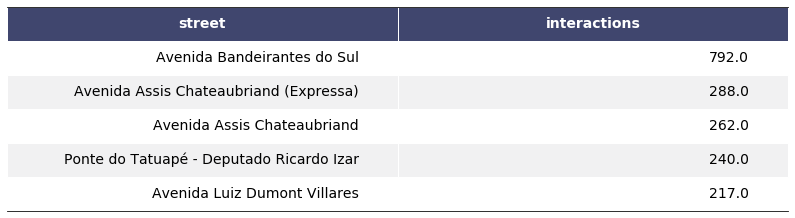

In [130]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=7)

\newpage

### Norte 2 <a class='tocSkip'>

In [131]:
region = 'Norte 2'

In [132]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

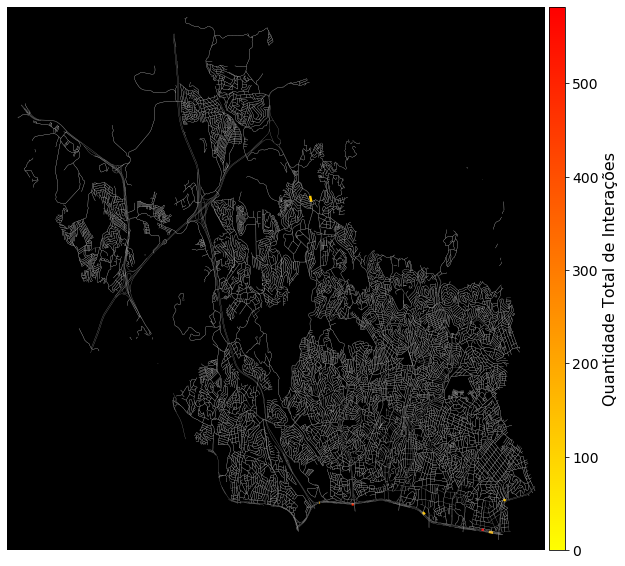

In [133]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

Tabela das Vias que concentram 10% das reclamações na região Norte 2.

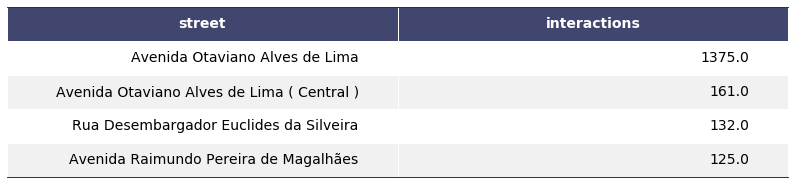

In [134]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=7)

\newpage

### Oeste <a class='tocSkip'>

In [135]:
region = 'Oeste'

In [136]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

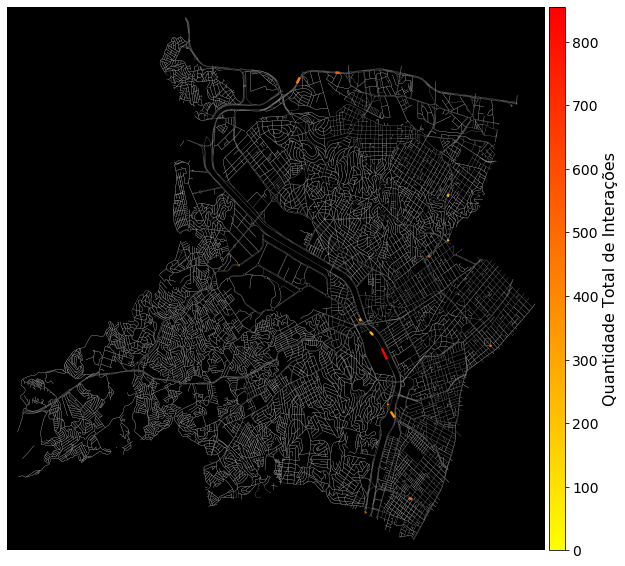

In [137]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

Tabela das Vias que concentram 10% das reclamações na região Oeste.

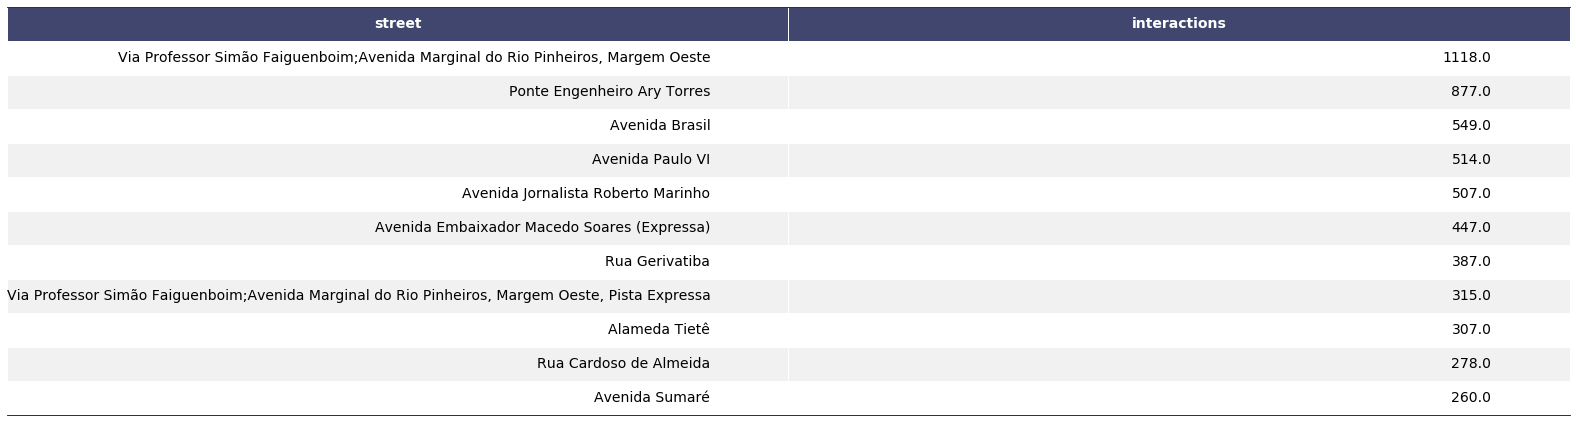

In [138]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=14)

\newpage

### Leste 1 <a class='tocSkip'>

In [139]:
region = 'Leste 1'

In [140]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

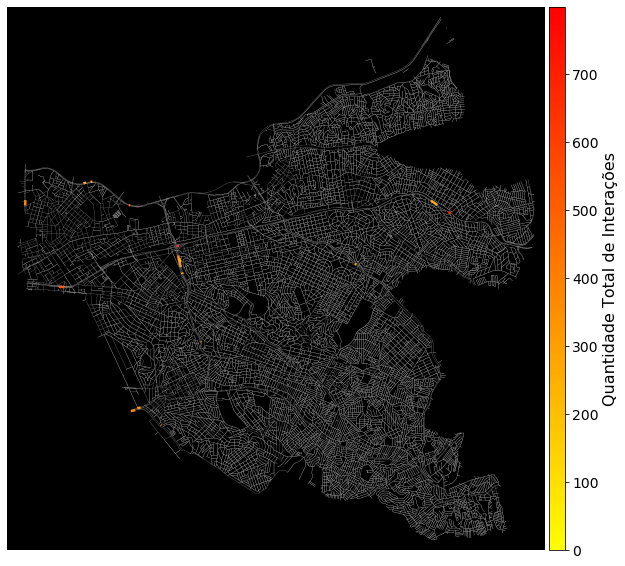

In [141]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

\newpage

Tabela das Vias que concentram 10% das reclamações na região Leste 1.

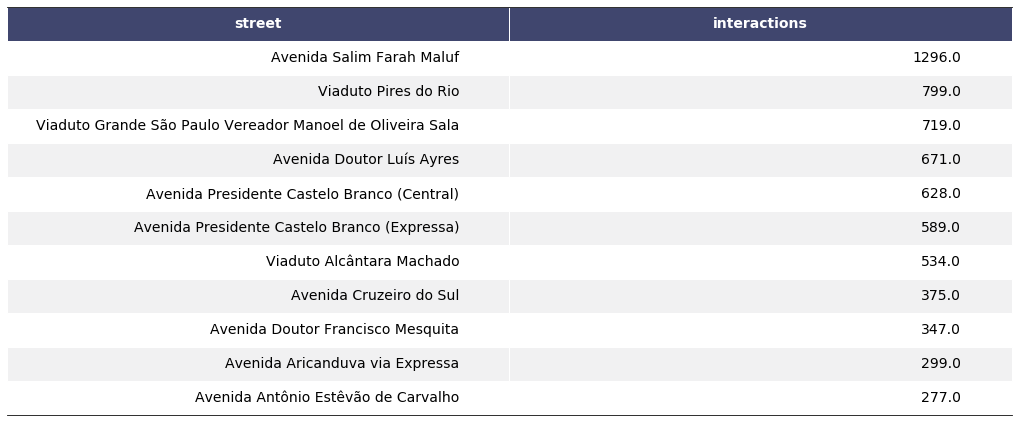

In [142]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=9)

\newpage

### Leste 2 <a class='tocSkip'>

In [143]:
region = 'Leste 2'

In [144]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

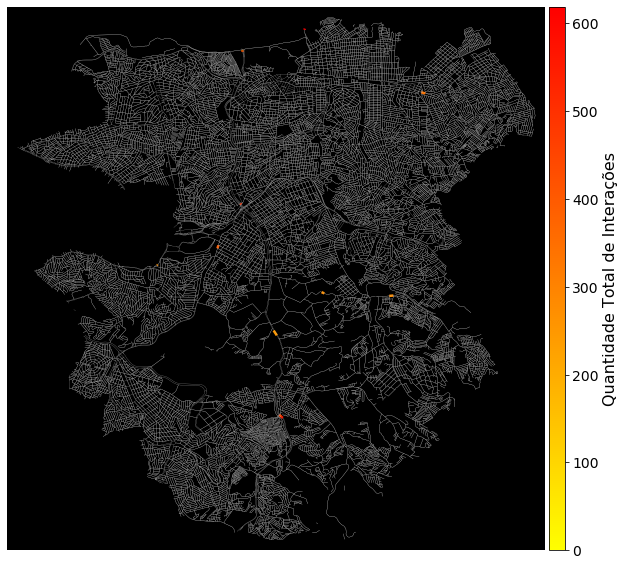

In [145]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

Tabela das Vias que concentram 10% das reclamações na região Leste 2.

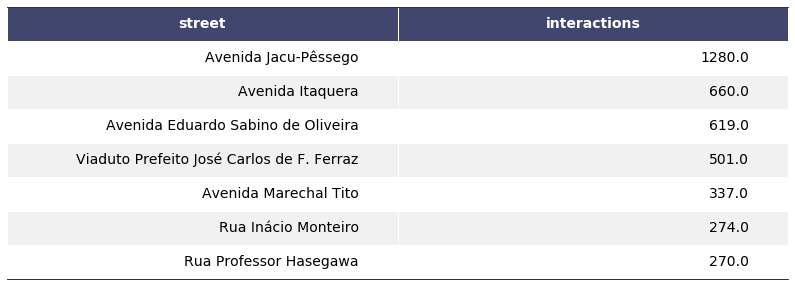

In [146]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=7)

\newpage

### Sul 1 <a class='tocSkip'>

In [147]:
region = 'Sul 1'

In [148]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

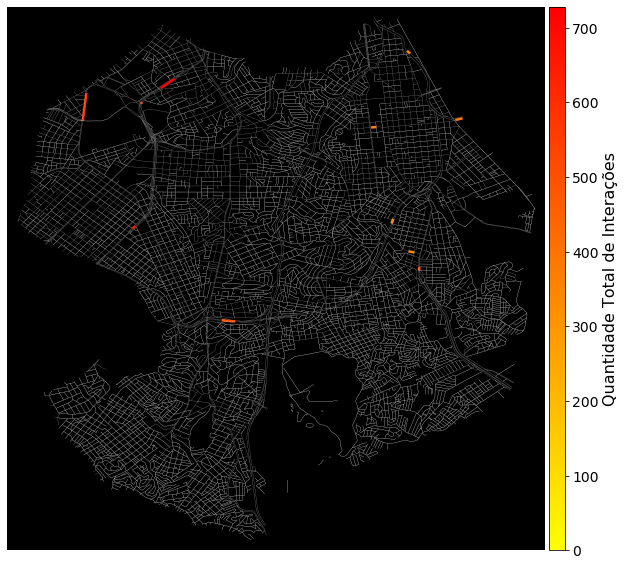

In [149]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

\newpage

Tabela das Vias que concentram 10% das reclamações na região Sul 1.

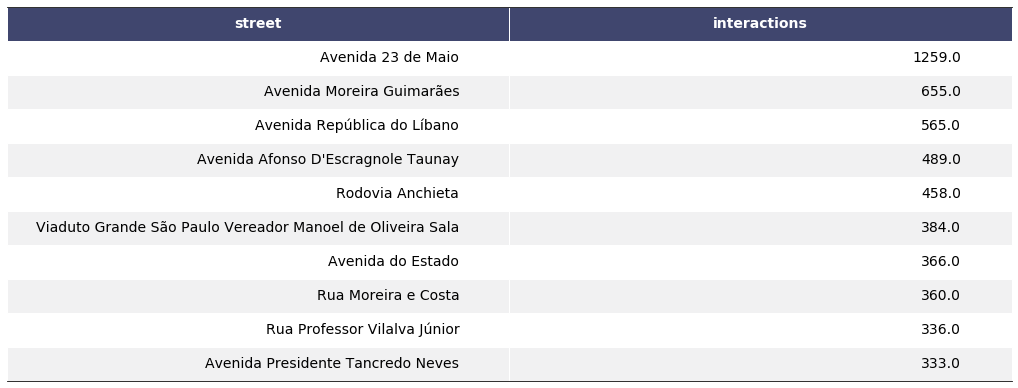

In [150]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=9)

\newpage

### Sul 2 <a class='tocSkip'>

In [151]:
region = 'Sul 2'

In [152]:
edges_with_potholes_pareto = edges_pareto[(edges_pareto[f'pareto_{region}'] < top)]
edges_with_potholes_pareto = edges_with_potholes_pareto.groupby(['u','v','k']).sum().to_dict('index')
nx.set_edge_attributes(Graphs_copy[region], edges_with_potholes_pareto)

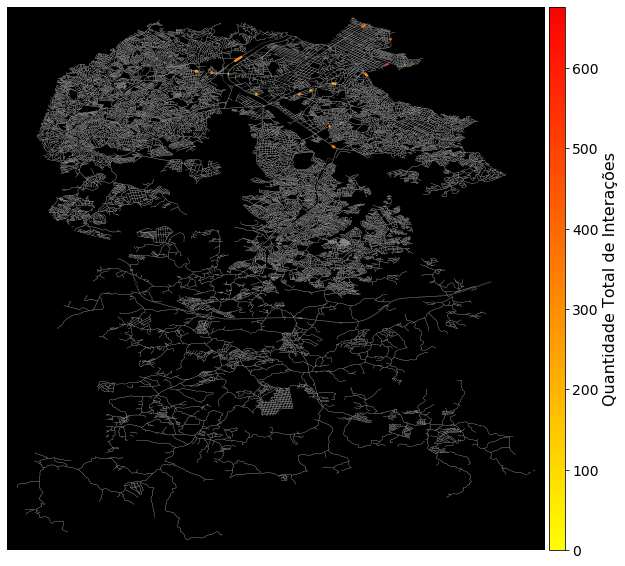

In [153]:
phc.plot_graph_potholes(Graphs_copy[region],fig_width=10, fig_height=10)

Tabela das Vias que concentram 10% das reclamações na região Sul 2.

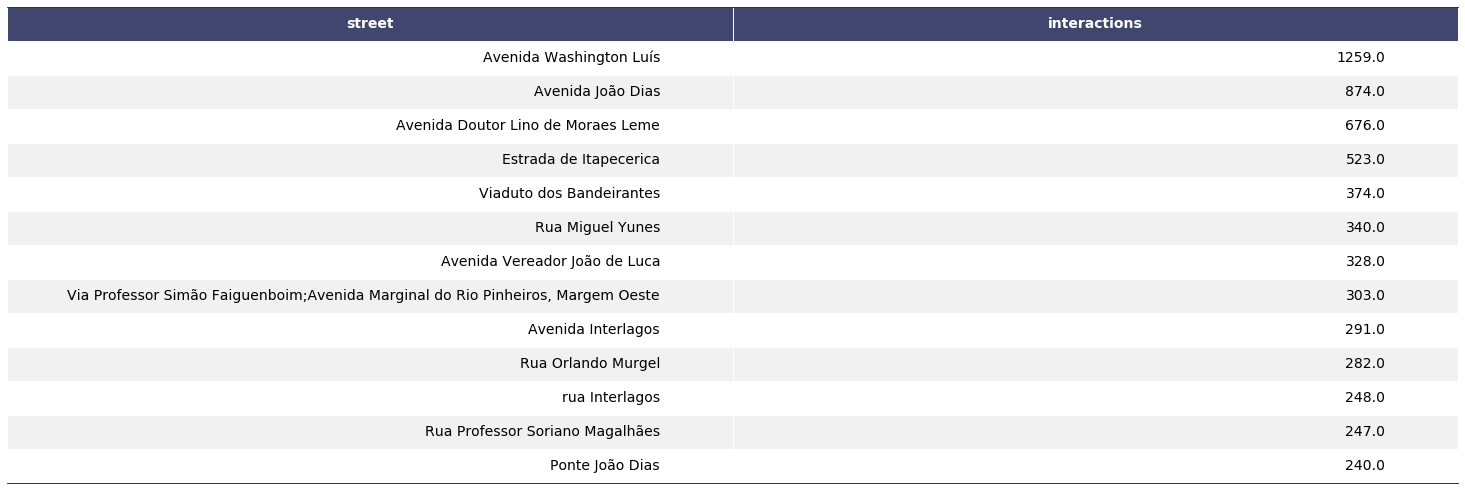

In [154]:
edges_table = edges[edges['alerts_count']>0].loc[:,['alerts_count', 'interactions', 'cost', 'name', f'pareto_{region}']].rename(columns={'name':'street', 'alerts_count':'alerts count'})

top = 10
display(Markdown(f"""Tabela das Vias que concentram {top}% das reclamações na região {region}."""))
with pd.option_context('display.max_rows', None):
    edges_table = edges_table.loc[edges_table[f'pareto_{region}'] < top, ['street', 'interactions']].groupby('street').sum().sort_values('interactions', ascending=False).reset_index()
    fig, ax, table = phc.render_mpl_table(edges_table, 'remove.png', city, col_width=13)

\newpage

# Export to Kepler <a class='tocSkip'>

In [99]:
kepler_data = phc.export_kepler(city, edges)